In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import KFold

from treend import *
from reg_tree import *

from os import listdir
from os.path import isfile, join

# online source :https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

data_path = "../../../../machine learning/checkdatasets/PRSA_Data_20130301-20170228/"


files = [f for f in listdir(data_path)]

frames= []
for file in files:
    if file[-4:] == ".csv" :
        d = pd.read_csv(data_path+file)
        frames.append(d)

df = pd.concat(frames)

# for coding purpose, use a smaller dataset
#df=df.sample(frac=.0005)

# only predict O3
df=df.drop(columns=['No','PM2.5', 'PM10', 'SO2', 'NO2', 'CO'])

# get attributes columns 
attributes = list(df.columns).copy()
attributes.remove('O3')

# drop every row having a missing value in O3, our target, or in station (we do not know from where the data comes from)
df.dropna(subset=["O3","station"], inplace=True)

df_origin = df.copy()

df.head()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [2]:
# returns a table with the percentage of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d
number_of_samples_per_number_of_missing_values(df).map(lambda x: x/len(df))

0    0.995470
1    0.003561
2    0.000022
4    0.000182
5    0.000020
6    0.000746
Name: missing values in row, dtype: float64

In [3]:
# returns a table with the percentage of missing values per attribute

df.isna().sum().map(lambda x: x/len(df))

year       0.000000
month      0.000000
day        0.000000
hour       0.000000
O3         0.000000
TEMP       0.000960
PRES       0.000947
DEWP       0.000972
RAIN       0.000940
wd         0.004319
WSPM       0.000768
station    0.000000
dtype: float64

In [4]:
df.describe()

,year,month,day,hour,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,407491.000000,407491.000000,407491.000000,407491.000000,407491.000000,407100.000000,407105.000000,407095.000000,407108.000000,407178.000000
mean,2014.672152,6.502355,15.728902,11.543666,57.372271,13.589864,1010.711416,2.489784,0.065201,1.736377
std,1.175809,3.443240,8.798008,6.918263,56.661607,11.436452,10.471908,13.823238,0.828276,1.249161
min,2013.000000,1.000000,1.000000,0.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,6.000000,11.000000,3.200000,1002.200000,-9.000000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,12.000000,45.000000,14.600000,1010.300000,3.100000,0.000000,1.400000
75%,2016.000000,9.000000,23.000000,18.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


We can see that our dataset has relatively a small amount of missing values, so we will delete the missing values (we can assume that these values are Missing Completely at Random, ie the fact that the value is missing has nothing to do with its hypothetical value and with the values of other variables, because here we it is just a lack of data due to weather station and we can suppose that no bias is introduced if we drop rows with missing values.
To be sure of this assumption, we will try with the total deletion of the rows with missing values (here printed for the preprocessing), and then with a threshold of 3 missing values at most for a row, and finally with an imputation for everything.
We will use two kind of preprocessing: mean value (and most common value for non numeral values) and 5NN.

# Preprocessing

In [5]:
from sklearn.impute import KNNImputer

# drop rows with missing values

def dropRows(df, wds=[], thres=0, imputation=None) :
    
    if imputation == "mean" :
        # wind direction is nominal so we have to check for every created column (wds)
        for wd in wds :
            df[wd] = df[wd].fillna(df[wd].mode()[0])
        # for numeral values
        missing_list = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        for name in missing_list:
            df[name] = df[name].fillna(df[name].mean())
        return df
    elif imputation == "5NN" :
        imp = KNNImputer(n_neighbors=5)
        # we fit the multivariate feature imputation
        imp.fit(df)
        # we use it on training dataset
        array = imp.transform(df)
        return pd.DataFrame(array, columns = df.columns)
    else :
        return df.dropna(thresh=len(df.columns)-thres)
    
df = dropRows(df)

<Figure size 432x288 with 0 Axes>

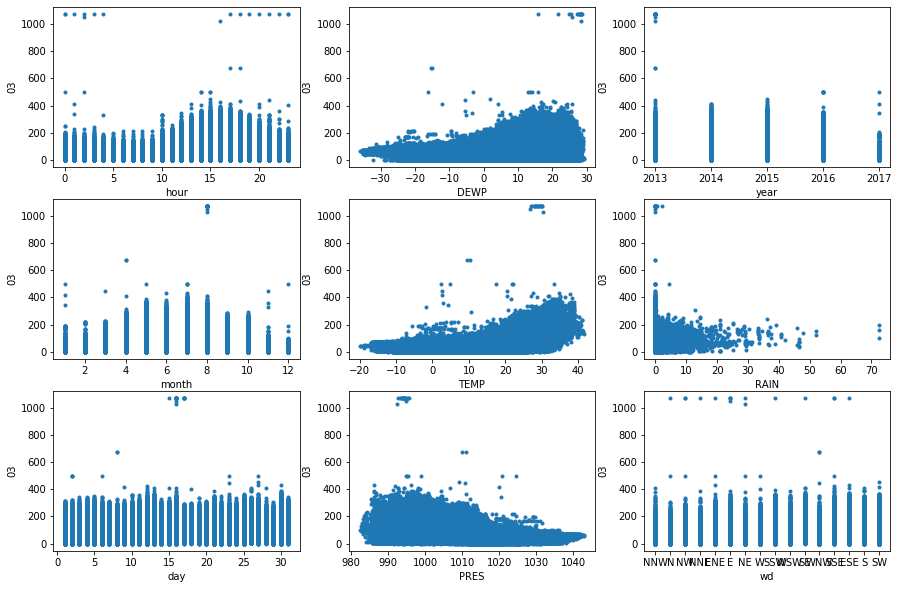

In [6]:
# plots scatter graph with the mean value of the target for each value of the attribute (string imput)
# log is true when we want to plot it with a logarithmic scale

def plotTargetPerAttribute(data, attribute, ax=plt, logx=False, logy=False) :
    if logx :
        ax.semilogx(data[attribute], data["O3"])
    elif logy :
        ax.semilogy(data[attribute], data["O3"])
    else :
        ax.plot(data[attribute], data["O3"], '.')
    ax.set(xlabel=attribute)
    ax.set(ylabel="03")
    #ax.savefig("./max_iter_ppn.pdf")

def plotAllAttributes(data) :
    plt.clf()
    fig, axs = plt.subplots(3,3, figsize = (15,10))
    j = -1
    for i in range(9) :
        attribute = attributes[i]
        plotTargetPerAttribute(data, attribute, axs[i%3][j])
        if i%3 == 0:
            j += 1
    plt.savefig("../figures/airquality/plot_all_attributes.jpeg")

plotAllAttributes(df)

In [7]:
def removeOutliers(df) :
    if 'O3' in df.columns :
        df = df[df['O3'] < 1000]
    return df
    
# get the O3 index
indO3 = None

# returns the 5 datasets with the 5 methods of preprocessing

def preprocessing(df) :
    # encode columns by one hot
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')

    df1 = dropRows(df, thres=0, imputation=None)
    df2 = dropRows(df, wds=wds, thres=4, imputation="mean")
    df3 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="mean")
    df4 = dropRows(df, wds=wds, thres=4, imputation="5NN")
    df5 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="5NN")
    DF = [df1,df2,df3,df4,df5]
    for i in range(len(DF)) :
        DF[i] = removeOutliers(DF[i])
        DF[i] = np.array(DF[i]).astype("float")
    return DF
 
def preprocessing_mean(df) :
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    df = dropRows(df, thres=(len(df_origin)-1), imputation="mean")
    df = removeOutliers(df)
    return np.array(df).astype("float")

In [ ]:
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2 = [[] for i in range(5)], [[] for i in range(5)]
M5regressor_MAE_model, const_regressor_MAE = [[] for i in range(5)], [[] for i in range(5)]

# We split the data and apply the pre-processing

for train_index, test_index in split:
        array_train = df_origin.iloc[train_index]
        array_test = df_origin.iloc[test_index]
        
        trains = preprocessing(pd.DataFrame(data=array_train, columns=df_origin.columns))
        tests = preprocessing(pd.DataFrame(data=array_test, columns=df_origin.columns))

        for i in range(5) :
            y_train = trains[i][:,indO3]
            y_test = tests[i][:,indO3]
            X_train = np.delete(trains[i], indO3, axis=1)
            X_test = np.delete(tests[i], indO3, axis=1)
            
            #M5 regressor tree own
            reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
            M5regressor_r2_model[i].append(r2_score(y_test, reg.predict(X_test)))
            M5regressor_MAE_model[i].append(mean_absolute_error(y_test, reg.predict(X_test)))

            #Constant regressor tree own
            reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
            const_regressor_r2[i].append(r2_score(y_test, reg2.predict(X_test)))
            const_regressor_MAE[i].append(mean_absolute_error(y_test, reg2.predict(X_test)))
            
m5_r2, cons_r2 = [], []
for i in range(5):
    m5_r2.append(np.mean(M5regressor_r2_model[i]))
    cons_r2.append(np.mean(const_regressor_r2[i]))

print("m5_r2:", m5_r2)
print("cons_r2:", cons_r2)

calc split of 271382 points
dim, split 4 25.95
calc split of 227849 points
dim, split 4 17.5
calc split of 154094 points
dim, split 8 2.1
calc split of 110895 points
dim, split 1 7.0
calc split of 57472 points
dim, split 4 3.5
calc split of 53423 points
dim, split 4 13.15
calc split of 43199 points
dim, split 1 6.0
calc split of 28508 points
dim, split 4 6.275
calc split of 14691 points
dim, split 6 -0.9
calc split of 73755 points
dim, split 3 12.0
calc split of 39581 points
dim, split 1 7.0
calc split of 17086 points
dim, split 8 1.5
calc split of 22495 points
dim, split 4 20.544444444444398
calc split of 34174 points
dim, split 1 6.0
calc split of 12965 points
dim, split 4 22.4
calc split of 21209 points
dim, split 4 22.7
calc split of 43533 points
dim, split 3 12.0
calc split of 11787 points
dim, split 3 10.0
calc split of 6479 points
dim, split 3 2.0
calc split of 1319 points
dim, split 1 7.0
calc split of 5160 points
dim, split 1 7.0
calc split of 5308 points
dim, split 4 29.7
cal

Make it a leaf backup
calc split of 139 points
calc split of 41 points
calc split of 26 points
calc split of 15 points
calc split of 98 points
calc split of 55 points
calc split of 43 points
calc split of 1132 points
calc split of 657 points
calc split of 621 points
calc split of 452 points
calc split of 169 points
calc split of 36 points
calc split of 14 points
calc split of 22 points
calc split of 475 points
calc split of 51 points
calc split of 23 points
calc split of 28 points
calc split of 424 points
calc split of 397 points
calc split of 27 points
calc split of 5160 points
calc split of 962 points
calc split of 658 points
calc split of 330 points
calc split of 280 points
calc split of 50 points
calc split of 328 points
calc split of 98 points
calc split of 230 points
calc split of 304 points
calc split of 79 points
calc split of 7 points
calc split of 72 points
calc split of 225 points
calc split of 31 points
calc split of 194 points
calc split of 4198 points
calc split of 1237 p

calc split of 5873 points
calc split of 11547 points
calc split of 5166 points
calc split of 2586 points
calc split of 2580 points
calc split of 6381 points
calc split of 4047 points
calc split of 2334 points
calc split of 53465 points
calc split of 42765 points
calc split of 7194 points
calc split of 5567 points
calc split of 2308 points
calc split of 3259 points
calc split of 1627 points
calc split of 1505 points
calc split of 122 points
calc split of 35571 points
calc split of 24055 points
calc split of 13214 points
calc split of 10841 points
calc split of 11516 points
calc split of 2998 points
calc split of 8518 points
calc split of 10700 points
calc split of 5679 points
calc split of 2019 points
calc split of 1166 points
calc split of 853 points
calc split of 3660 points
calc split of 342 points
calc split of 3318 points
calc split of 5021 points
calc split of 2928 points
calc split of 2300 points
calc split of 628 points
calc split of 2093 points
calc split of 754 points
calc spl

calc split of 32 points
calc split of 21 points
calc split of 11 points
calc split of 1201 points
calc split of 731 points
calc split of 634 points
calc split of 97 points
calc split of 470 points
calc split of 131 points
calc split of 339 points
calc split of 31746 points
calc split of 15199 points
calc split of 6770 points
calc split of 1445 points
calc split of 1413 points
calc split of 1327 points
calc split of 1066 points
calc split of 261 points
calc split of 86 points
calc split of 10 points
calc split of 76 points
calc split of 32 points
calc split of 14 points
calc split of 9 points
calc split of 5 points
Make it a leaf backup
calc split of 18 points
calc split of 12 points
calc split of 6 points
Make it a leaf backup
calc split of 5325 points
calc split of 2283 points
calc split of 2137 points
calc split of 493 points
calc split of 1644 points
calc split of 146 points
calc split of 37 points
calc split of 109 points
calc split of 3042 points
calc split of 1350 points
calc spl

calc split of 39583 points
calc split of 17088 points
calc split of 9870 points
calc split of 3755 points
calc split of 1983 points
calc split of 998 points
calc split of 985 points
calc split of 1772 points
calc split of 1167 points
calc split of 605 points
calc split of 6115 points
calc split of 3268 points
calc split of 933 points
calc split of 2335 points
calc split of 2847 points
calc split of 1778 points
calc split of 1069 points
calc split of 7218 points
calc split of 3144 points
calc split of 398 points
calc split of 176 points
calc split of 222 points
calc split of 2746 points
calc split of 510 points
calc split of 2236 points
calc split of 4074 points
calc split of 2228 points
calc split of 1208 points
calc split of 1020 points
calc split of 1846 points
calc split of 974 points
calc split of 872 points
calc split of 22495 points
calc split of 6405 points
calc split of 5928 points
calc split of 1640 points
calc split of 900 points
calc split of 740 points
calc split of 4288 po

calc split of 1049 points
calc split of 715 points
calc split of 159 points
calc split of 103 points
calc split of 56 points
calc split of 556 points
calc split of 90 points
calc split of 466 points
calc split of 334 points
calc split of 191 points
calc split of 159 points
calc split of 32 points
calc split of 143 points
calc split of 15 points
calc split of 128 points
calc split of 13460 points
calc split of 2982 points
calc split of 598 points
calc split of 285 points
calc split of 278 points
calc split of 7 points
calc split of 313 points
calc split of 187 points
calc split of 126 points
calc split of 2384 points
calc split of 604 points
calc split of 121 points
calc split of 483 points
calc split of 1780 points
calc split of 1046 points
calc split of 734 points
calc split of 10478 points
calc split of 2091 points
calc split of 2055 points
calc split of 523 points
calc split of 1532 points
calc split of 36 points
calc split of 7 points
calc split of 29 points
calc split of 8387 poin

calc split of 21209 points
calc split of 11369 points
calc split of 10805 points
calc split of 6372 points
calc split of 2048 points
calc split of 4324 points
calc split of 4433 points
calc split of 3397 points
calc split of 1036 points
calc split of 564 points
calc split of 434 points
calc split of 302 points
calc split of 132 points
calc split of 130 points
calc split of 42 points
calc split of 88 points
calc split of 9840 points
calc split of 7677 points
calc split of 5161 points
calc split of 1152 points
calc split of 4009 points
calc split of 2516 points
calc split of 848 points
calc split of 1668 points
calc split of 2163 points
calc split of 1094 points
calc split of 281 points
calc split of 813 points
calc split of 1069 points
calc split of 552 points
calc split of 517 points
calc split of 43533 points
calc split of 11787 points
calc split of 6479 points
calc split of 1319 points
calc split of 187 points
calc split of 48 points
calc split of 44 points
calc split of 38 points
ca

dim, split 0 2014.0
calc split of 31746 points
dim, split 4 29.5
calc split of 15199 points
dim, split 1 7.0
calc split of 6770 points
dim, split 6 5.0
calc split of 8429 points
dim, split 3 22.0
calc split of 16547 points
dim, split 6 11.4
calc split of 3087 points
dim, split 1 7.0
calc split of 13460 points
dim, split 1 7.0
calc split of 271651 points
calc split of 228118 points
calc split of 154360 points
calc split of 111126 points
calc split of 57661 points
calc split of 29398 points
calc split of 6074 points
calc split of 2792 points
calc split of 784 points
calc split of 2008 points
calc split of 3282 points
calc split of 694 points
calc split of 2588 points
calc split of 23324 points
calc split of 1528 points
calc split of 911 points
calc split of 617 points
calc split of 21796 points
calc split of 10247 points
calc split of 11549 points
calc split of 28263 points
calc split of 16716 points
calc split of 1902 points
calc split of 1386 points
calc split of 516 points
calc split 

calc split of 744 points
calc split of 100 points
calc split of 393 points
calc split of 97 points
calc split of 296 points
calc split of 2961 points
calc split of 2043 points
calc split of 285 points
calc split of 1758 points
calc split of 918 points
calc split of 780 points
calc split of 138 points
calc split of 5308 points
calc split of 3181 points
calc split of 1290 points
calc split of 604 points
calc split of 207 points
calc split of 189 points
calc split of 18 points
calc split of 397 points
calc split of 52 points
calc split of 345 points
calc split of 686 points
calc split of 232 points
calc split of 220 points
calc split of 12 points
calc split of 454 points
calc split of 121 points
calc split of 333 points
calc split of 1891 points
calc split of 1145 points
calc split of 872 points
calc split of 229 points
calc split of 643 points
calc split of 273 points
calc split of 76 points
calc split of 197 points
calc split of 746 points
calc split of 725 points
calc split of 122 poin

calc split of 28411 points
calc split of 15601 points
calc split of 12205 points
calc split of 5810 points
calc split of 2626 points
calc split of 3184 points
calc split of 6395 points
calc split of 2375 points
calc split of 4020 points
calc split of 3396 points
calc split of 1251 points
calc split of 610 points
calc split of 641 points
calc split of 2145 points
calc split of 1872 points
calc split of 273 points
calc split of 12810 points
calc split of 3871 points
calc split of 1746 points
calc split of 783 points
calc split of 963 points
calc split of 2125 points
calc split of 59 points
calc split of 2066 points
calc split of 8939 points
calc split of 4133 points
calc split of 2756 points
calc split of 1377 points
calc split of 4806 points
calc split of 3637 points
calc split of 1169 points
calc split of 14884 points
calc split of 7873 points
calc split of 6150 points
calc split of 2669 points
calc split of 477 points
calc split of 2192 points
calc split of 3481 points
calc split of 2

calc split of 779 points
calc split of 712 points
calc split of 67 points
calc split of 61 points
calc split of 6 points
calc split of 55 points
calc split of 20 points
calc split of 35 points
calc split of 4913 points
calc split of 2168 points
calc split of 2015 points
calc split of 451 points
calc split of 1564 points
calc split of 153 points
calc split of 36 points
calc split of 117 points
calc split of 2745 points
calc split of 1855 points
calc split of 399 points
calc split of 1456 points
calc split of 890 points
calc split of 222 points
calc split of 668 points
calc split of 7456 points
calc split of 6129 points
calc split of 1262 points
calc split of 942 points
calc split of 234 points
calc split of 708 points
calc split of 320 points
calc split of 150 points
calc split of 170 points
calc split of 4867 points
calc split of 3515 points
calc split of 1382 points
calc split of 2133 points
calc split of 1352 points
calc split of 293 points
calc split of 1059 points
calc split of 132

calc split of 482 points
calc split of 2288 points
calc split of 4083 points
calc split of 2590 points
calc split of 1520 points
calc split of 1070 points
calc split of 1493 points
calc split of 792 points
calc split of 701 points
calc split of 22928 points
calc split of 6458 points
calc split of 6006 points
calc split of 5589 points
calc split of 1320 points
calc split of 4269 points
calc split of 417 points
calc split of 206 points
calc split of 211 points
calc split of 452 points
calc split of 103 points
calc split of 39 points
calc split of 64 points
calc split of 349 points
calc split of 320 points
calc split of 29 points
calc split of 16470 points
calc split of 5945 points
calc split of 4714 points
calc split of 4447 points
calc split of 267 points
calc split of 1231 points
calc split of 909 points
calc split of 322 points
calc split of 10525 points
calc split of 2574 points
calc split of 776 points
calc split of 1798 points
calc split of 7951 points
calc split of 6512 points
cal

calc split of 11572 points
calc split of 5609 points
calc split of 1158 points
calc split of 176 points
calc split of 982 points
calc split of 4451 points
calc split of 3840 points
calc split of 611 points
calc split of 5963 points
calc split of 1390 points
calc split of 1354 points
calc split of 36 points
calc split of 4573 points
calc split of 451 points
calc split of 4122 points
calc split of 271648 points
dim, split 4 25.95
calc split of 227893 points
dim, split 4 17.5
calc split of 153873 points
dim, split 8 2.1
calc split of 110549 points
dim, split 1 7.0
calc split of 57490 points
dim, split 4 3.7
calc split of 53059 points
dim, split 4 13.15
calc split of 43324 points
dim, split 1 6.0
calc split of 28429 points
dim, split 4 6.125
calc split of 14895 points
dim, split 8 3.3
calc split of 74020 points
dim, split 3 12.0
calc split of 39943 points
dim, split 1 7.0
calc split of 17015 points
dim, split 8 1.5
calc split of 22928 points
dim, split 4 20.575
calc split of 34077 points
d

calc split of 1370 points
calc split of 801 points
calc split of 569 points
calc split of 43755 points
calc split of 11841 points
calc split of 6535 points
calc split of 1275 points
calc split of 210 points
calc split of 79 points
calc split of 5 points
Make it a leaf backup
calc split of 74 points
calc split of 25 points
calc split of 49 points
calc split of 131 points
calc split of 17 points
calc split of 9 points
calc split of 8 points
calc split of 114 points
calc split of 47 points
calc split of 67 points
calc split of 1065 points
calc split of 827 points
calc split of 111 points
calc split of 78 points
calc split of 33 points
calc split of 716 points
calc split of 391 points
calc split of 325 points
calc split of 238 points
calc split of 221 points
calc split of 202 points
calc split of 19 points
calc split of 17 points
calc split of 10 points
calc split of 7 points
calc split of 5260 points
calc split of 1015 points
calc split of 708 points
calc split of 359 points
calc split of

calc split of 22228 points
calc split of 10004 points
calc split of 12224 points
calc split of 27473 points
calc split of 16250 points
calc split of 1945 points
calc split of 1418 points
calc split of 527 points
calc split of 14305 points
calc split of 7379 points
calc split of 6926 points
calc split of 11223 points
calc split of 4882 points
calc split of 2494 points
calc split of 2388 points
calc split of 6341 points
calc split of 3985 points
calc split of 2356 points
calc split of 53059 points
calc split of 42454 points
calc split of 6989 points
calc split of 5311 points
calc split of 2255 points
calc split of 3056 points
calc split of 1678 points
calc split of 1268 points
calc split of 410 points
calc split of 35465 points
calc split of 23929 points
calc split of 11634 points
calc split of 12295 points
calc split of 11536 points
calc split of 3528 points
calc split of 8008 points
calc split of 10605 points
calc split of 1942 points
calc split of 867 points
calc split of 415 points
c

calc split of 650 points
calc split of 25 points
calc split of 13 points
calc split of 12 points
calc split of 1991 points
calc split of 570 points
calc split of 148 points
calc split of 71 points
calc split of 4 points
calc split of 67 points
calc split of 77 points
calc split of 60 points
calc split of 17 points
calc split of 422 points
calc split of 205 points
calc split of 23 points
calc split of 182 points
calc split of 217 points
calc split of 184 points
calc split of 33 points
calc split of 1421 points
calc split of 299 points
calc split of 76 points
calc split of 56 points
calc split of 20 points
calc split of 223 points
calc split of 102 points
calc split of 121 points
calc split of 1122 points
calc split of 204 points
calc split of 157 points
calc split of 47 points
calc split of 918 points
calc split of 873 points
calc split of 45 points
calc split of 31914 points
calc split of 13516 points
calc split of 6060 points
calc split of 1147 points
calc split of 1086 points
calc sp

calc split of 384 points
calc split of 691 points
calc split of 1430 points
calc split of 356 points
calc split of 1074 points
calc split of 4507 points
calc split of 4298 points
calc split of 3102 points
calc split of 1196 points
calc split of 209 points
calc split of 77 points
calc split of 132 points
calc split of 74020 points
calc split of 39943 points
calc split of 17015 points
calc split of 9773 points
calc split of 2829 points
calc split of 1451 points
calc split of 816 points
calc split of 635 points
calc split of 1378 points
calc split of 771 points
calc split of 607 points
calc split of 6944 points
calc split of 3330 points
calc split of 857 points
calc split of 2473 points
calc split of 3614 points
calc split of 3003 points
calc split of 611 points
calc split of 7242 points
calc split of 3159 points
calc split of 389 points
calc split of 164 points
calc split of 225 points
calc split of 2770 points
calc split of 482 points
calc split of 2288 points
calc split of 4083 points


calc split of 345 points
calc split of 187 points
calc split of 158 points
calc split of 18398 points
calc split of 3263 points
calc split of 2242 points
calc split of 1074 points
calc split of 951 points
calc split of 852 points
calc split of 99 points
calc split of 123 points
calc split of 120 points
calc split of 1168 points
calc split of 590 points
calc split of 318 points
calc split of 272 points
calc split of 578 points
calc split of 137 points
calc split of 441 points
calc split of 1021 points
calc split of 629 points
calc split of 585 points
calc split of 80 points
calc split of 505 points
calc split of 44 points
calc split of 8 points
calc split of 36 points
calc split of 392 points
calc split of 299 points
calc split of 202 points
calc split of 97 points
calc split of 93 points
calc split of 40 points
calc split of 53 points
calc split of 15135 points
calc split of 3563 points
calc split of 794 points
calc split of 617 points
calc split of 359 points
calc split of 258 points


calc split of 1661 points
calc split of 488 points
calc split of 1173 points
calc split of 742 points
calc split of 312 points
calc split of 430 points
calc split of 4072 points
calc split of 1989 points
calc split of 793 points
calc split of 298 points
calc split of 495 points
calc split of 1196 points
calc split of 274 points
calc split of 922 points
calc split of 2083 points
calc split of 1549 points
calc split of 299 points
calc split of 1250 points
calc split of 534 points
calc split of 501 points
calc split of 33 points
calc split of 21773 points
calc split of 12498 points
calc split of 7534 points
calc split of 2349 points
calc split of 1743 points
calc split of 606 points
calc split of 5185 points
calc split of 1299 points
calc split of 3886 points
calc split of 4964 points
calc split of 4476 points
calc split of 3507 points
calc split of 969 points
calc split of 488 points
calc split of 289 points
calc split of 199 points
calc split of 9275 points
calc split of 7268 points
cal

dim, split 1 6.0
calc split of 13795 points
dim, split 4 22.9
calc split of 21773 points
dim, split 4 22.7
calc split of 45621 points
dim, split 3 12.0
calc split of 12615 points
dim, split 3 10.0
calc split of 7137 points
dim, split 3 2.0
calc split of 1446 points
dim, split 1 7.0
calc split of 5691 points
dim, split 1 7.0
calc split of 5478 points
dim, split 4 29.0
calc split of 2759 points
dim, split 1 7.0
calc split of 2719 points
dim, split 0 2014.0
calc split of 33006 points
dim, split 4 29.5
calc split of 16226 points
dim, split 1 7.0
calc split of 7197 points
dim, split 6 5.0
calc split of 9029 points
dim, split 3 22.0
calc split of 16780 points
dim, split 6 11.4
calc split of 3183 points
dim, split 1 7.0
calc split of 13597 points
dim, split 1 7.0
calc split of 271651 points
calc split of 226030 points
calc split of 149132 points
calc split of 107367 points
calc split of 55980 points
calc split of 30118 points
calc split of 6180 points
calc split of 2772 points
calc split of 7

calc split of 103 points
calc split of 166 points
calc split of 4633 points
calc split of 3196 points
calc split of 898 points
calc split of 585 points
calc split of 313 points
calc split of 2298 points
calc split of 342 points
calc split of 1956 points
calc split of 1437 points
calc split of 1040 points
calc split of 342 points
calc split of 698 points
calc split of 397 points
calc split of 185 points
calc split of 212 points
calc split of 5478 points
calc split of 2759 points
calc split of 1180 points
calc split of 558 points
calc split of 246 points
calc split of 231 points
calc split of 15 points
calc split of 312 points
calc split of 34 points
calc split of 278 points
calc split of 622 points
calc split of 210 points
calc split of 51 points
calc split of 159 points
calc split of 412 points
calc split of 131 points
calc split of 281 points
calc split of 1579 points
calc split of 1163 points
calc split of 68 points
calc split of 61 points
calc split of 7 points
calc split of 1095 po

calc split of 27413 points
calc split of 15624 points
calc split of 12055 points
calc split of 5654 points
calc split of 2971 points
calc split of 2683 points
calc split of 6401 points
calc split of 2336 points
calc split of 4065 points
calc split of 3569 points
calc split of 1183 points
calc split of 385 points
calc split of 798 points
calc split of 2386 points
calc split of 1387 points
calc split of 999 points
calc split of 11789 points
calc split of 4269 points
calc split of 2044 points
calc split of 386 points
calc split of 1658 points
calc split of 2225 points
calc split of 1554 points
calc split of 671 points
calc split of 7520 points
calc split of 3049 points
calc split of 2072 points
calc split of 977 points
calc split of 4471 points
calc split of 3337 points
calc split of 1134 points
calc split of 14352 points
calc split of 12359 points
calc split of 5920 points
calc split of 2581 points
calc split of 326 points
calc split of 2255 points
calc split of 3339 points
calc split of

calc split of 527 points
calc split of 1675 points
calc split of 142 points
calc split of 32 points
calc split of 110 points
calc split of 3292 points
calc split of 1585 points
calc split of 326 points
calc split of 1259 points
calc split of 1707 points
calc split of 227 points
calc split of 1480 points
calc split of 9029 points
calc split of 7563 points
calc split of 1516 points
calc split of 1126 points
calc split of 273 points
calc split of 853 points
calc split of 390 points
calc split of 181 points
calc split of 209 points
calc split of 6047 points
calc split of 4222 points
calc split of 3299 points
calc split of 923 points
calc split of 1825 points
calc split of 1671 points
calc split of 154 points
calc split of 1466 points
calc split of 749 points
calc split of 83 points
calc split of 50 points
calc split of 33 points
calc split of 666 points
calc split of 457 points
calc split of 209 points
calc split of 717 points
calc split of 367 points
calc split of 33 points
calc split of 

calc split of 1565 points
calc split of 1102 points
calc split of 1656 points
calc split of 902 points
calc split of 754 points
calc split of 23198 points
calc split of 7546 points
calc split of 7034 points
calc split of 6253 points
calc split of 4215 points
calc split of 2038 points
calc split of 781 points
calc split of 408 points
calc split of 373 points
calc split of 512 points
calc split of 304 points
calc split of 203 points
calc split of 101 points
calc split of 208 points
calc split of 158 points
calc split of 50 points
calc split of 15652 points
calc split of 5786 points
calc split of 5254 points
calc split of 4430 points
calc split of 824 points
calc split of 532 points
calc split of 465 points
calc split of 67 points
calc split of 9866 points
calc split of 2415 points
calc split of 725 points
calc split of 1690 points
calc split of 7451 points
calc split of 6134 points
calc split of 1317 points
calc split of 35568 points
calc split of 13795 points
calc split of 9723 points
c

calc split of 2347 points
calc split of 2313 points
calc split of 583 points
calc split of 1730 points
calc split of 34 points
calc split of 9 points
calc split of 25 points
calc split of 8248 points
calc split of 5768 points
calc split of 5305 points
calc split of 463 points
calc split of 2480 points
calc split of 232 points
calc split of 2248 points
calc split of 271651 points
dim, split 4 25.725
calc split of 226030 points
dim, split 4 16.8
calc split of 149132 points
dim, split 8 2.1
calc split of 107367 points
dim, split 1 7.0
calc split of 55980 points
dim, split 4 3.7
calc split of 51387 points
dim, split 4 13.0
calc split of 41765 points
dim, split 1 6.0
calc split of 27413 points
dim, split 4 6.3
calc split of 14352 points
dim, split 6 -0.9


# Parameters tuning

We can notice that the difference can be ignored, so we will use the mean without deleting any value.

# Constant regressor tree

In [ ]:
# preprocessing with only mean value
# we use a simple split and just optimize the train part and have a regard to the test part (or validation) in order 
# to avoid overfitting. We do not use grid search because it is too time costly.

train_set, test_set = train_test_split(df_origin, test_size=0.2, random_state=42)
train_set = preprocessing_mean(train_set)
test_set = preprocessing_mean(test_set)
train_target = trains[i][:,indO3]
test_target = tests[i][:,indO3]
train = np.delete(trains[i], indO3, axis=1)
test = np.delete(tests[i], indO3, axis=1)

# number of cross validation
cv = 2

# maximum depth
vals = np.arange(2,11,2)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = 4, max_depth=x).fit(train, train_target[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_cons.jpeg")

The optimal depth seems to be 8. Now we optimize the number of attributes per leaf.

In [ ]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = x, max_depth=8).fit(train, train_target[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_cons.jpeg")

The optimal number of attributes per leaf could be 1. We will use these parameters to compare to the other algorithms.

# M5 regressor tree

In [ ]:
# max depth
vals = np.arange(2,11,2)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=x,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_M5.jpeg")

It seems that the best value is 6.

In [ ]:
# number of attributes per leaf
vals = np.arange(1,10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=x, max_depth=6,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_M5.jpeg")

It seems not to change a lot, let's take the default value.

In [ ]:
# k
vals = np.arange(5,31,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=x,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/k_M5.jpeg")

k=12 seems quite optimal to avoid overfitting.

In [ ]:
# pruning
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/pruning_M5.jpeg")

We need pruning to avoid overfitting.

In [ ]:
# smoothing
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/smoothing_M5.jpeg")

We need smoothing to avoid overfitting.

In [ ]:
# optimize models
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=x,incremental_fit=True).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/opti_model_M5.jpeg")

There is no real difference so we will still optimize models.

In [ ]:
# incremental fit
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=x).fit(X_train, y_train[:,None])
    #r2_test.append(cross_val_score(reg, test, test_target, scoring='r2', cv=cv).mean())
    #r2_train.append(cross_val_score(reg, train, train_target, scoring='r2', cv=cv).mean())
    #MAE_test.append(cross_val_score(reg, test, test_target, scoring='max_error', cv=cv).mean())
    #MAE_train.append(cross_val_score(reg, train, train_target, scoring='max_error', cv=cv).mean())
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/incr_fit_M5.jpeg")

We need incremental fit to avoid overfitting.

# Compare with existing algorithms

We can notice that the difference can be ignored, so we will just delete the samples with missing data during the preprocessing phase.

In [ ]:
import timeit

kf = KFold(n_splits=10, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2, const_regressor_sklearn_r2_model, linear_regressor_r2, random_forest_regressor_r2, extra_tree_r2 = [], [], [], [], [], []
M5regressor_MAE_model, const_regressor_MAE, const_regressor_sklearn_MAE_model, linear_regressor_MAE, random_forest_regressor_MAE, extra_tree_MAE = [], [], [], [], [], []
times = {"M5":-1, "cons":-1, "cons_sk":-1, "linear":-1, "random_forest":-1, "extratree":-1}

# We split the data and apply the pre-processing

for train_index, test_index in split:
    
        train_set = preprocessing_mean(df_origin.iloc[train_index])
        test_set = preprocessing_mean(df_origin.iloc[test_index])
        y_train = trains[i][:,indO3]
        y_test = tests[i][:,indO3]
        X_train = np.delete(trains[i], indO3, axis=1)
        X_test = np.delete(tests[i], indO3, axis=1)

        #M5 regressor tree own
        start = timeit.default_timer()
        reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=6,k=12.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
        M5regressor_r2_model.append(r2_score(y_test, reg.predict(X_test)))
        M5regressor_MAE_model.append(mean_absolute_error(y_test, reg.predict(X_test)))
        times["M5"] = timeit.default_timer()-start
        
        #Constant regressor tree own
        start = timeit.default_timer()
        reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
        const_regressor_r2.append(r2_score(y_test, reg2.predict(X_test)))
        const_regressor_MAE.append(mean_absolute_error(y_test, reg2.predict(X_test)))
        times["cons"] = timeit.default_timer()-start
        
        #Constant regressor tree SKlearn #SAME PARAMETERS AS OURS?
        start = timeit.default_timer()
        const_regressor_sklearn = tree.DecisionTreeRegressor(min_samples_leaf=4, max_depth=8, random_state=42).fit(X_train, y_train)
        const_regressor_sklearn_r2_model.append(r2_score(y_test, const_regressor_sklearn.predict(X_test)))
        const_regressor_sklearn_MAE_model.append(mean_absolute_error(y_test, const_regressor_sklearn.predict(X_test)))
        times["cons_sk"] = timeit.default_timer()-start
        #Linear regression sklearn
        start = timeit.default_timer()
        linear_regressor = LinearRegression().fit(X_train, y_train)
        linear_regressor_r2.append(r2_score(y_test, linear_regressor.predict(X_test)))
        linear_regressor_MAE.append(mean_absolute_error(y_test, linear_regressor.predict(X_test)))
        times["linear"] = timeit.default_timer()-start
        # Random forrest regressor
        start = timeit.default_timer()
        random_forest_regressor = RandomForestRegressor(max_depth=8, min_samples_split=4, random_state=42).fit(X_train, y_train)
        random_forest_regressor_r2.append(r2_score(y_test, random_forest_regressor.predict(X_test)))
        random_forest_regressor_MAE.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))
        times["random_forest"] = timeit.default_timer()-start
        #Extra tree regressor
        start = timeit.default_timer()
        extra_tree_regressor = ExtraTreeRegressor(max_depth=8, random_state=42).fit(X_train, y_train)
        extra_tree_r2.append(r2_score(y_test, extra_tree_regressor .predict(X_test)))
        extra_tree_MAE.append(mean_absolute_error(y_test, extra_tree_regressor .predict(X_test)))
        times["extratree"] = timeit.default_timer()-start


m5_r2 = np.mean(M5regressor_r2_model)
cons_r2 = np.mean(const_regressor_r2)                                           
cons_sklearn_r2 = np.mean(const_regressor_sklearn_r2_model)   
linear_r2 = np.mean(linear_regressor_r2)
random_r2 =np.mean(random_forest_regressor_r2)
extra_r2= np.mean(extra_tree_r2)
m5_MAE = np.mean(M5regressor_MAE_model)
cons_MAE = np.mean(const_regressor_MAE)                                           
cons_sklearn_MAE = np.mean(const_regressor_sklearn_MAE_model)   
linear_MAE = np.mean(linear_regressor_MAE)
random_MAE =np.mean(random_forest_regressor_MAE)
extra_MAE = np.mean(extra_tree_MAE)
print("m5 r2", m5_r2, "MAE", m5_MAE )
print("cons r2",cons_r2, "MAE", cons_MAE  )
print("cons_sklearn r2", cons_sklearn_r2, "MAE", cons_sklearn_MAE) 
print("linear r2", linear_r2, "MAE", linear_MAE)
print("random r2", random_r2, "MAE", random_MAE)
print("extra r2", extra_r2, "MAE", extra_MAE)
print(times)

In [ ]:
objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
r2score = [m5_r2,cons_r2,cons_sklearn_r2,linear_r2,random_r2,1]

plt.bar(y_pos, r2score, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('R2 score')
plt.title('R2 score per model')
plt.savefig("../figures/airquality/r2scores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
MAEscore = [m5_MAE,cons_MAE,cons_sklearn_MAE,linear_MAE,random_MAE,1]

plt.bar(y_pos, MAEscore, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('MAE score')
plt.title('MAE score per model')
plt.savefig("../figures/airquality/MAEscores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))

plt.bar(y_pos, times.values(), align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Execution time per model')